In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import os

In [ ]:
os.chdir('input/data')
os.getcwd()

In [30]:
!find . -regex ".*\.\_[a-zA-Z0-9._]+" -delete

In [2]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
train_dir_path = '/opt/ml/input/data/train/'
train_image_path = '/opt/ml/input/data/train/images/'

dt_train = pd.read_csv(train_dir_path+'train.csv')
dt_train

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [4]:
whole_image_path = []
whole_target_label = []

for path in dt_train['path']:
    for file_name in [i for i in os.listdir(train_image_path+path) if '._' not in i]:
        whole_image_path.append(train_image_path+path+'/'+file_name)
        whole_target_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))

In [5]:
def onehot_enc(x):
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 3
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        elif j >= 60:
            return 2
    def mask(k):
        if k == 'normal':
            return 12
        elif 'incorrect' in k:
            return 6
        else:
            return 0
    return gender(x[0]) + age(x[1]) + mask(x[2])

In [6]:
def enc_genmsk(x):
    # x 입력형식 : (성별, 나이, 마스크) 튜플
    # 출력형식 : (나이, 성별-마스크 인코딩) 튜플
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 3
    def mask(k):
        if k == 'normal':
            return 12
        elif 'incorrect' in k:
            return 6
        else:
            return 0
    if int(x[1]) == 60:
        return 70, (gender(x[0])+mask(x[2]))//3
    return int(x[1]), (gender(x[0])+mask(x[2]))//3

In [5]:
def enc_sepclass(x):
    # x 입력형식 : (성별, 나이, 마스크) 튜플
    # 출력형식 : (성별인코딩, 나이인코딩, 마스크인코딩)
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 1
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        else:
            return 2
    def mask(k):
        if k == 'normal':
            return 2
        elif 'incorrect' in k:
            return 1
        else:
            return 0
    return gender(x[0]), age(x[1]), mask(x[2])

In [6]:
sr_data = pd.Series(whole_image_path)
sr_label = pd.Series(whole_target_label)

In [7]:
class Dataset_Mask(Dataset):
    def __init__(self, encoding=True, midcrop=True, transform=None):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = sr_data
        self.label = sr_label
        self.transform = transform
        
        if encoding:
            self.label = self.label.apply(enc_sepclass)
        
    def __len__(self):
        return len(sr_data)
    
    def __getitem__(self, idx):
        X = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        y = self.label[idx]
        
        if self.midcrop:
            X = X[98:422, 30:354]
        
        if self.transform:
            return self.transform(X), y
        return X, y

In [8]:
dataset_mask = Dataset_Mask(transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

In [9]:
train_size = int(len(dataset_mask) * 0.8)
val_size = int(len(dataset_mask) * 0.2)

In [10]:
mask_train_set, mask_val_set = torch.utils.data.random_split(dataset_mask, [train_size, val_size])
print(f'training data size : {len(mask_train_set)}')
print(f'validation data size : {len(mask_val_set)}')

training data size : 15120
validation data size : 3780


In [11]:
batch_size = 256
train_dataloader_mask = DataLoader(dataset = mask_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader_mask = DataLoader(dataset = mask_val_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
class R34_RegCls(torchvision.models.ResNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.out1 = nn.Linear(512, 2, bias=True)
        self.out2 = nn.Linear(512, 3, bias=True)
        self.out3 = nn.Linear(512, 3, bias=True)
        
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # out1 : gender class
        # out2 : age class
        # out3 : mask class
        out1 = self.out1(x)
        out2 = self.out2(x)
        out3 = self.out3(x)
        
        return out1, out2, out3

In [13]:
block = torchvision.models.resnet.BasicBlock
layers = [3, 4, 6, 3]

basemodel_resnet34 = R34_RegCls(block = block, layers = layers)
print('필요 입력 채널 개수', basemodel_resnet34.conv1.weight.shape[1])
print('네트워크 출력 채널 개수_gen/msk', basemodel_resnet34.out1.weight.shape[0])
print('네트워크 출력 채널 개수_age', basemodel_resnet34.out2.weight.shape[0])
print(basemodel_resnet34)

필요 입력 채널 개수 3
네트워크 출력 채널 개수_gen/msk 2
네트워크 출력 채널 개수_age 3
R34_RegCls(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [14]:
import math
nn.init.xavier_uniform_(basemodel_resnet34.out1.weight)
stdv = 1. / math.sqrt(basemodel_resnet34.out1.weight.size(1))
basemodel_resnet34.out1.bias.data.uniform_(-stdv, stdv)

nn.init.xavier_uniform_(basemodel_resnet34.out2.weight)
stdv = 1. / math.sqrt(basemodel_resnet34.out2.weight.size(1))
basemodel_resnet34.out2.bias.data.uniform_(-stdv, stdv)

nn.init.xavier_uniform_(basemodel_resnet34.out3.weight)
stdv = 1. / math.sqrt(basemodel_resnet34.out3.weight.size(1))
basemodel_resnet34.out3.bias.data.uniform_(-stdv, stdv)

tensor([-0.0264, -0.0118,  0.0335])

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

basemodel_resnet34.to(device)

LEARNING_RATE = 0.0001
NUM_EPOCH = 30

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basemodel_resnet34.parameters(), lr=LEARNING_RATE)

using cuda:0


In [16]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(basemodel_resnet34.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[conv1.weight] shape:[(64, 3, 7, 7)].
    val:[ 0.004  0.025 -0.02  -0.018 -0.03 ]
[1] name:[bn1.weight] shape:[(64,)].
    val:[1. 1. 1. 1. 1.]
[2] name:[bn1.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[3] name:[layer1.0.conv1.weight] shape:[(64, 64, 3, 3)].
    val:[ 0.044 -0.094  0.078 -0.065 -0.008]
[4] name:[layer1.0.bn1.weight] shape:[(64,)].
    val:[1. 1. 1. 1. 1.]
[5] name:[layer1.0.bn1.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[layer1.0.conv2.weight] shape:[(64, 64, 3, 3)].
    val:[-0.023  0.043 -0.038 -0.07  -0.1  ]
[7] name:[layer1.0.bn2.weight] shape:[(64,)].
    val:[1. 1. 1. 1. 1.]
[8] name:[layer1.0.bn2.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[9] name:[layer1.1.conv1.weight] shape:[(64, 64, 3, 3)].
    val:[ 0.008 -0.065  0.001  0.023 -0.004]
[10] name:[layer1.1.bn1.weight] shape:[(64,)].
    val:[1. 1. 1. 1. 1.]
[11] name:[layer1.1.bn1.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[12] name:[layer1.1.conv2.weight] shape:[(64, 64, 3, 3)].


In [17]:
# print되는 값들은 정확하지 않을 수도 있습니다 (진행상황 보려고 대강 확인안하고 만들었어요)

total_sum = 0

for epoch in range(NUM_EPOCH):
    loss_value = 0
    basemodel_resnet34.train()

    for inputs, labels in train_dataloader_mask:
        inputs = inputs.to(device)
        gen, age, msk = labels
        gen = gen.to(device)
        age = age.to(device)
        msk = msk.to(device)
        
        p_gen, p_age, p_msk = basemodel_resnet34(inputs)
        p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)
        loss = criterion(p_gen, gen) + criterion(p_age, age) + criterion(p_msk, msk)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = loss.item() / len(inputs)
    print('> train_loss : {}'.format(train_loss))     
    
    
    basemodel_resnet34.eval()
    for idx, (inputs, labels) in enumerate(val_dataloader_mask):
        inputs = inputs.to(device)
        gen, age, msk = labels
        gen = gen.to(device)
        age = age.to(device)
        msk = msk.to(device)
        
        with torch.no_grad():
            p_gen, p_age, p_msk = basemodel_resnet34(inputs)
            p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)
        loss = criterion(p_gen, gen) + criterion(p_age, age) + criterion(p_msk, msk)
        
        acc_1 = (gen == torch.argmax(p_gen, -1)).sum().item()
        acc_2 = (age == torch.argmax(p_age, -1)).sum().item()
        acc_3 = (msk == torch.argmax(p_msk, -1)).sum().item()
    
    valid_loss = loss / len(inputs)
    print('> valid_loss : {}'.format(valid_loss))    
    print(f'valid acc : {(acc_1 + acc_2 + acc_3) / (3 * len(inputs))}')        
        
    print(f"epoch[{epoch+1}/{NUM_EPOCH}] completed")        

/tmp/ipykernel_10466/3501907160.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)


> train_loss : 0.11433611810207367


/tmp/ipykernel_10466/3501907160.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_gen, p_age, p_msk = F.softmax(p_gen), F.softmax(p_age), F.softmax(p_msk)


> valid_loss : 0.010540408082306385
valid acc : 0.7789115646258503
epoch[1/30] completed
> train_loss : 0.10401048511266708
> valid_loss : 0.010556266643106937
valid acc : 0.7806122448979592
epoch[2/30] completed
> train_loss : 0.11068312078714371
> valid_loss : 0.008887164294719696
valid acc : 0.8928571428571429
epoch[3/30] completed
> train_loss : 0.1003379374742508
> valid_loss : 0.01029300782829523
valid acc : 0.7959183673469388
epoch[4/30] completed
> train_loss : 0.08876042068004608
> valid_loss : 0.00896081980317831
valid acc : 0.8877551020408163
epoch[5/30] completed
> train_loss : 0.10144273936748505
> valid_loss : 0.009222377091646194
valid acc : 0.8673469387755102
epoch[6/30] completed
> train_loss : 0.10932314395904541
> valid_loss : 0.008682835847139359
valid acc : 0.9047619047619048
epoch[7/30] completed
> train_loss : 0.09647645056247711
> valid_loss : 0.008630017749965191
valid acc : 0.9013605442176871
epoch[8/30] completed
> train_loss : 0.10906515270471573
> valid_los

In [18]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir_path = '/opt/ml/input/data/eval/'
test_image_path = '/opt/ml/input/data/eval/images/'

submission = pd.read_csv(test_dir_path+'info.csv')
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [19]:
image_paths = [os.path.join(test_image_path, img_id) for img_id in submission.ImageID]
test_image = pd.Series(image_paths)

In [20]:
class Test_Dataset(Dataset):
    def __init__(self, midcrop=True, transform=None):
        self.midcrop = midcrop
        self.data = test_image
        self.transform = transform
        
    def __len__(self):
        return len(test_image)
    
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        
        if self.midcrop:
            img = img[98:422, 30:354]
            
        if self.transform:
            img = self.transform(img)
            
        return img

In [21]:
dataset = Test_Dataset(transform = transforms.Compose([
                            transforms.ToTensor()
                        ]))

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = basemodel_resnet34.to(device)
model.eval()


# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        p_gen, p_age, p_msk = model(images)
        
        ar_gen = p_gen.argmax(dim=-1)
        ar_age = p_age.argmax(dim=-1)
        ar_msk = p_msk.argmax(dim=-1)
        
        total = ar_gen * 3 + ar_age + ar_msk * 6
        
        all_predictions.extend(total.cpu().numpy())
submission['ans'] = all_predictions


# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir_path, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


In [22]:
# 결과비교 (자체, 현재 제출된 것 중 가장 결과가 좋은 것과 비교)
# 기준결과의 accuracy가 a%, 비교결과가 b%인 경우
#  -> 현재 결과의 accuracy 범위 : a+b-100(%) ~ a-b+100(%)
standard = pd.read_csv('./log/standard_1028.csv')['ans']
100 * sum(standard == submission['ans']) / len(standard)

74.22222222222223

In [148]:
# (자체) 각 class별로 정답개수 확인
g_sum = 0
a_sum = 0
m_sum = 0
device = torch.device('cuda')
model = basemodel_resnet34.to(device)
model.eval()

for i in range(18900):
    image, label = dataset_mask[i]
    image = image.unsqueeze(0).to(device)
    
    result = model(image)
    if torch.argmax(result[0]) == label[0]:
        g_sum += 1
    if torch.argmax(result[1]) == label[1]:
        a_sum += 1
    if torch.argmax(result[2]) == label[2]:
        m_sum += 1

print(g_sum, a_sum , m_sum)

18780 17423 18869


In [144]:
# 실제로 확인(in train set : idx = 0~18900)
image, label = dataset_mask[3333]
image = image.unsqueeze(0).to(device)


device = torch.device('cuda')
model = basemodel_resnet34.to(device)
model.eval()

result = model(image)

In [149]:
print('---- (Gender , Age, Mask) <--Pred  //  Real--> (Gender, Age, Mask) ----')
(torch.argmax(result[0]), torch.argmax(result[1]), torch.argmax(result[2])), (label[0], label[1], label[2])

---- (Gender , Age, Mask) <--Pred  //  Real--> (Gender, Age, Mask) ----


((tensor(0, device='cuda:0'),
  tensor(0, device='cuda:0'),
  tensor(0, device='cuda:0')),
 (0, 0, 0))

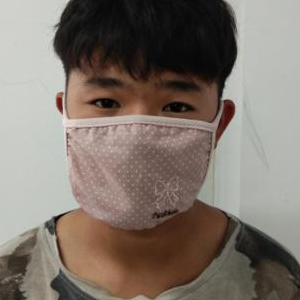

In [150]:
# 데이터와 예측라벨, 실제라벨 확인
print(torch.argmax(result[0]) * 3 + torch.argmax(result[1]) + torch.argmax(result[2]) * 6, label[0]*3 + label[1] + label[2]*6)
transforms.ToPILImage()(image.squeeze())